In [457]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [458]:
#Variables
path = "../HUPA-UC Diabetes Dataset/"
demographic_path = path + "T1DM_patient_sleep_demographics_with_race.csv"
all_patients_path = path + "ALL_PATIENTS.csv"
modified_demographic_path = path+"DEMOGRAPHIC.csv"
patients_demographic_path = path +"PATIENTS_WITH_DEMOGRAPHIC.csv"

In [459]:
patients_df = pd.read_csv(all_patients_path, parse_dates=["time"])
#patients_demographic_df = pd.read_csv(patients_demographic_path,parse_dates=["time"])
demographic_df = pd.read_csv(modified_demographic_path)
patients_df.columns

Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input', 'patient_id'],
      dtype='object')

**What is the average glucose level for patients between midnight and 5 AM?**

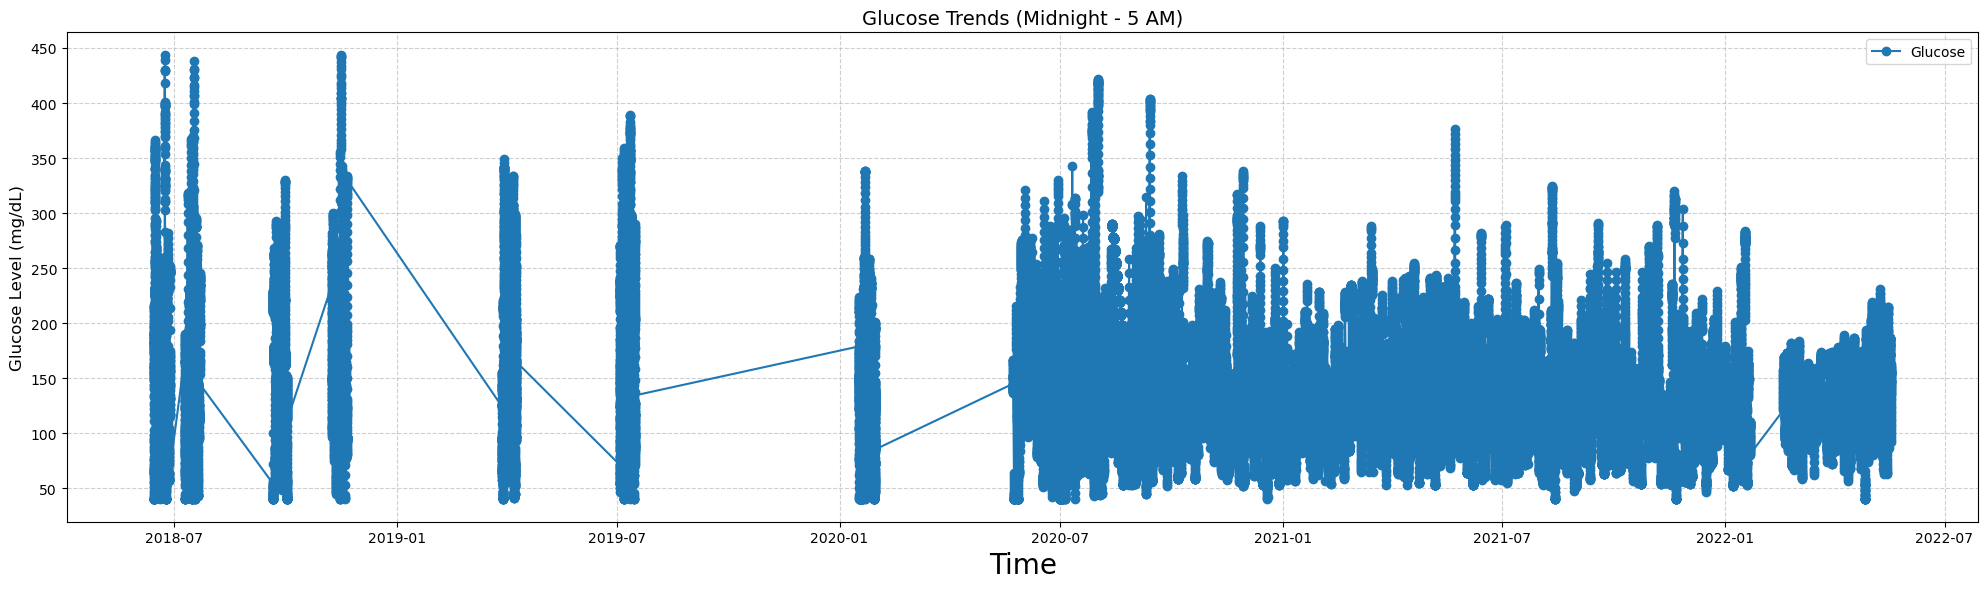

In [4]:
early_morning_df  = patients_df[(patients_df["time"].dt.hour >=0) & (patients_df["time"].dt.hour<5)].copy()
#early_morning_df.columns
#early_morning_df.head()
plt.figure(figsize=(20,6))
#for pid,group in early_morning_df.groupby("patient_id"):
#plt.plot(group["time"],group["glucose"], marker="o", linestyle="-", lable =pid)
plt.plot(early_morning_df["time"], early_morning_df["glucose"],label="Glucose",marker="o")
plt.title("Glucose Trends (Midnight - 5 AM)", fontsize=14)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Glucose Level (mg/dL)", fontsize=12)
#plt.legend(Title="Patient_Id", bbox_to_anchor=(1.05,1),loc="upper_left")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

**Problem Statement : Compare overnight and daytime glucose levels across patients**

**Reasoning: Overnight (midnight–5 AM) glucose reflects basal insulin and fasting state. 
             and Daytime glucose is influenced by meals,activity,stress and bolus insulin.
             Comparing these two periods helps clinical assess whether insulin delivery(basal/bolus) or                          lifestyle modificiations like diet,exercise are effective**

In [5]:
# Steps:
# Create seperate dataframes for daytime and overnight dataset
# daytime_df: This dataframe contains avg glucose values taken during the daytime per patient per day.
# columns are:
#patient id: Patient Id
#date part from time column: This column used to join the overnight dataset to get avgerage of glucose values recorded during overnight on that day 
#is_daytime: This column identifies the at what day part the glucose reading is recorded
#daytime_avg_glucose: This column has a avg glucose value for all records in daytime period on a single day

#------------------------------------------------------------
#Adding extra date column while grouping for daytime
#Extracting all glucose values for the 
# daytime[from 6am till 12am] grouping by patient_id and date
#-------------------------------------------------------------
daytime_df = patients_df.assign(date=patients_df['time'].dt.date,is_daytime = patients_df['time'].dt.hour.between(6,23)).groupby(['patient_id','date','is_daytime'])['glucose'].mean().reset_index()
#------------------------------------------------------------
# Delete all rows having is_daytime == False ie records other 
# than daytime
#------------------------------------------------------------
daytime_df=daytime_df[daytime_df['is_daytime']==True]
#------------------------------------------------------------
# rename the glucose column with daytime_avg_glucose
# renaming to clean join with the overnight dataframe
#------------------------------------------------------------
daytime_df=daytime_df.rename(columns={'glucose':'daytime_avg_glucose'})
#------------------------------------------------------------
# Number of patients having records during daytime
#------------------------------------------------------------
print('Total number of patients having records during daytime: ' , daytime_df['patient_id'].nunique())
#------------------------------------------------------------
# Number of days having records during midnight
#------------------------------------------------------------
print('Total number of days on which glucose has recorded during daytime:', daytime_df['date'].nunique())

#------------------------------------------------------------
# Adding extra date column while grouping for daytime
# Extracting all glucose values for the daytime[from midnight till 6am] grouping by patient_id and date
#------------------------------------------------------------
overnight_df= patients_df.assign(date=patients_df['time'].dt.date,is_overnight = patients_df['time'].dt.hour.between(0,5)).groupby(['patient_id','date','is_overnight'])['glucose'].mean().reset_index()
#overnight_df
#------------------------------------------------------------
# Delete all rows having is_daytime == False ie records other than daytime
#------------------------------------------------------------
overnight_df=overnight_df[overnight_df['is_overnight']==True]
#------------------------------------------------------------
# rename the glucose column with daytime_avg_glucose
# renaming to clean join with the overnight dataframe
#------------------------------------------------------------
overnight_df = overnight_df.rename(columns={'glucose':'overnight_avg_glucose'})
#overnight_df.count()
#overnight_df
#------------------------------------------------------------
# Number of patients having records during overnight
#------------------------------------------------------------
print('Total number of patients having records during overnight: ' , overnight_df['patient_id'].nunique())
#------------------------------------------------------------
# Number of days having records during midnight
#------------------------------------------------------------
print('Total number of days on which glucose has recorded during overnight:', overnight_df['date'].nunique())

#------------------------------------------------------------
# Join two df on patient_id and date 
#------------------------------------------------------------
result_df = pd.merge(daytime_df, overnight_df, on = ['patient_id','date'], how="inner") #,suffixes=('_daytime_avg_','_overnight_avg_'))
#------------------------------------------------------------
# Rounding avg glucose values to 1
#------------------------------------------------------------
result_df = result_df.round({
    'daytime_avg_glucose':1,
    'overnight_avg_glucose':1
})
result_df['date'].nunique()
result_df['patient_id'].nunique()
#------------------------------------------------------------
# Number of patients having records during overnight and daytime on the same day
#------------------------------------------------------------
print('Total number of patients having records during overnight: ' , result_df['patient_id'].nunique())
#------------------------------------------------------------
# Number of days having records during midnight and daytime
#------------------------------------------------------------
print('Total number of days on which glucose has recorded during overnight:', result_df['date'].nunique())
#result_df.columns
#------------------------------------------------------------
# Number of records during overnight and daytime on the same day for a patient
#------------------------------------------------------------
print('Total number records during overnight and daytime on the same day for a patient:', len(result_df))

result_df[['patient_id','date','daytime_avg_glucose','overnight_avg_glucose']]


#------------------------------------------------------------
# Find the patients having less difference between 
# DayTime and Overnight average glucose values
#------------------------------------------------------------
result_df['diff'] = (result_df['daytime_avg_glucose'] - result_df['overnight_avg_glucose']).abs()
#------------------------------------------------------------
# Patients having the minimum difference in daytime and overnight avg glucose reading per day
#------------------------------------------------------------
min_diff_index = result_df['diff'].idxmin()
print('------------------------------------------------------------------------------------------')
print('Patient having the minimum difference in daytime and overnight avg glucose reading day:')
print(result_df.loc[min_diff_index,['patient_id','date','daytime_avg_glucose','overnight_avg_glucose']])
print('------------------------------------------------------------------------------------------')
#------------------------------------------------------------
# Patients having the maximum difference in daytime and overnight avg glucose reading per day
#------------------------------------------------------------
max_diff_index = result_df['diff'].idxmax()
print('Patient having the maximum difference in daytime and overnight avg glucose reading day:')
print(result_df.loc[max_diff_index,['patient_id','date','daytime_avg_glucose','overnight_avg_glucose']])

#------------------------------------------------------------
# Patients getting spice in glucose values between 20 -50 units in daytime and overnight avg glucose reading per day
#------------------------------------------------------------
#max_diff_index = result_df['diff'].idxmax()
#print('Patient having the maximum difference in daytime and overnight avg glucose reading day:')
#print(result_df.loc[max_diff_index,['patient_id','date','daytime_avg_glucose','overnight_avg_glucose']])

#------------------------------------------------------------
# Number of Patients having lower overnight reading than daytime reading 
# Generally these paitents are non-diabetic or well-controlled diabetic patients
#------------------------------------------------------------
rows = result_df.loc[result_df['daytime_avg_glucose']>= result_df['overnight_avg_glucose'],
['patient_id','date','overnight_avg_glucose', 'daytime_avg_glucose']]
print('------------------------------------------------------------------------------------------')
print('Number of Patients with overnight avgerage glucose lower than \nor equal to the daytime glucose reading per day: ',len(rows))
print('Generally these paitents are non-diabetic or well-controlled diabetic patients')
print('------------------------------------------------------------------------------------------')
# rows.reset_index(drop=True)
#result_df
#------------------------------------------------------------
# Number of Patients with overnight avgerage glucose greater than 
# the daytime avg glucose reading by 50 mg/dLper day
# Difference more than 50mg/dL indicates risk of Hypoglycemia overnight
#------------------------------------------------------------
rows = result_df.loc[((result_df['daytime_avg_glucose']+50) < (result_df['overnight_avg_glucose'])),
['patient_id','date','overnight_avg_glucose', 'daytime_avg_glucose']]
print('Number of Patients with overnight avgerage glucose greater than \nthe daytime avg glucose reading by 50 mg/dLper day: ',len(rows))
print('Difference more than 50mg/dL indicates risk of Hypoglycemia overnight')
print('------------------------------------------------------------------------------------------')

#------------------------------------------------------------
# Number of patients whose overnight average glucose is greater than daytime glucose 
# by more than 20 mg/dL but less than 50 mg/dL per day.
# A difference of ~20–50 mg/dL is often reasonable;
#------------------------------------------------------------

rows = result_df.loc[(
        (result_df['overnight_avg_glucose']>result_df['daytime_avg_glucose'])&
        (result_df['overnight_avg_glucose'] - result_df['daytime_avg_glucose'] >=20 )&
        (result_df['overnight_avg_glucose'] - result_df['daytime_avg_glucose'] <=50 )),
        ['patient_id','date','overnight_avg_glucose', 'daytime_avg_glucose']]
print('Number of patients whose overnight average glucose is greater than daytime glucose \nby more than 20 mg/dL but less than 50 mg/dL per day: ',len(rows))
print('A difference of ~20–50 mg/dL is often reasonable')
print('------------------------------------------------------------------------------------------')
#------------------------------------------------------------
# Number of patients whose overnight average glucose is greater than daytime glucose 
# by less than 20 mg/dL per day
# A difference less than 20mg/dL is reasonable
#------------------------------------------------------------

rows = result_df.loc[(
        (result_df['overnight_avg_glucose']>result_df['daytime_avg_glucose'])&
        (result_df['overnight_avg_glucose'] - result_df['daytime_avg_glucose'] <20 )),
        ['patient_id','date','overnight_avg_glucose', 'daytime_avg_glucose']]
print('Number of patients whose overnight average glucose is greater than daytime glucose \nby less than 20 mg/dL per day: ',len(rows))
print('A difference less than 20mg/dL is reasonable')
print('\n**********Exact values can vary based on age, medications, and clinical recommendations.**********')

Total number of patients having records during daytime:  25
Total number of days on which glucose has recorded during daytime: 800
Total number of patients having records during overnight:  25
Total number of days on which glucose has recorded during overnight: 792
Total number of patients having records during overnight:  25
Total number of days on which glucose has recorded during overnight: 792
Total number records during overnight and daytime on the same day for a patient: 1071
------------------------------------------------------------------------------------------
Patient having the minimum difference in daytime and overnight avg glucose reading day:
patient_id                HUPA0028P
date                     2022-04-22
daytime_avg_glucose           106.1
overnight_avg_glucose         106.1
Name: 1044, dtype: object
------------------------------------------------------------------------------------------
Patient having the maximum difference in daytime and overnight avg glucos

<pre><strong>
Acceptable Difference (Spice) Between Overnight & Daytime

For non-diabetic or well-controlled diabetic patients, overnight readings are usually  
lower than daytime post-meal readings.  

A difference of ~20–50 mg/dL is often reasonable; larger differences may indicate:
    High postprandial spikes
    Hypoglycemia overnight 
    Need for insulin/diet adjustment

**PLEASE NOTE:  
Exact values can vary based on age, medications, and clinical recommendations.</strong></pre>

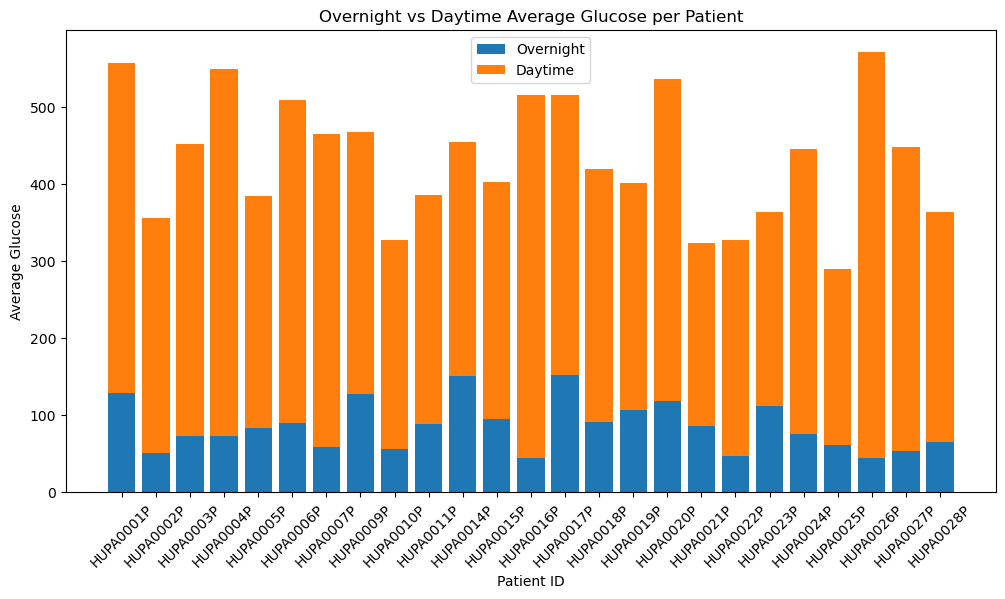

In [6]:

#Ploting grpah 
#It is taking a min and max values 
plt.figure(figsize=(12,6))
plt.bar(result_df['patient_id'], result_df['overnight_avg_glucose'], label='Overnight')
plt.bar(result_df['patient_id'], result_df['daytime_avg_glucose'], bottom=result_df['overnight_avg_glucose'], label='Daytime')
plt.xlabel("Patient ID")
plt.ylabel("Average Glucose")
plt.title("Overnight vs Daytime Average Glucose per Patient")
plt.xticks(rotation=45)
plt.legend()
plt.show()

**melt reshapes your DataFrame from wide format → long format.**  

**In wide format, ie. [result_df]  each patient-date has two separate columns for glucose. That’s harder to plot directly.**

**In long format,[pivot_df] both readings are stacked into a single avg_glucose column with a label (time_type) saying if it’s daytime or overnight.**

In [24]:
# reshape into long format
plot_df = result_df.melt(
    id_vars=["patient_id", "date"],
    value_vars=["daytime_avg_glucose", "overnight_avg_glucose"],
    var_name="time_type", value_name="avg_glucose"
)

**InPlot**  

**x="date" → x-axis = date**  

**y="avg_glucose" → bar height = glucose value**  

**hue="time_type" → separate colors for day vs. night**  


<Figure size 1400x600 with 0 Axes>

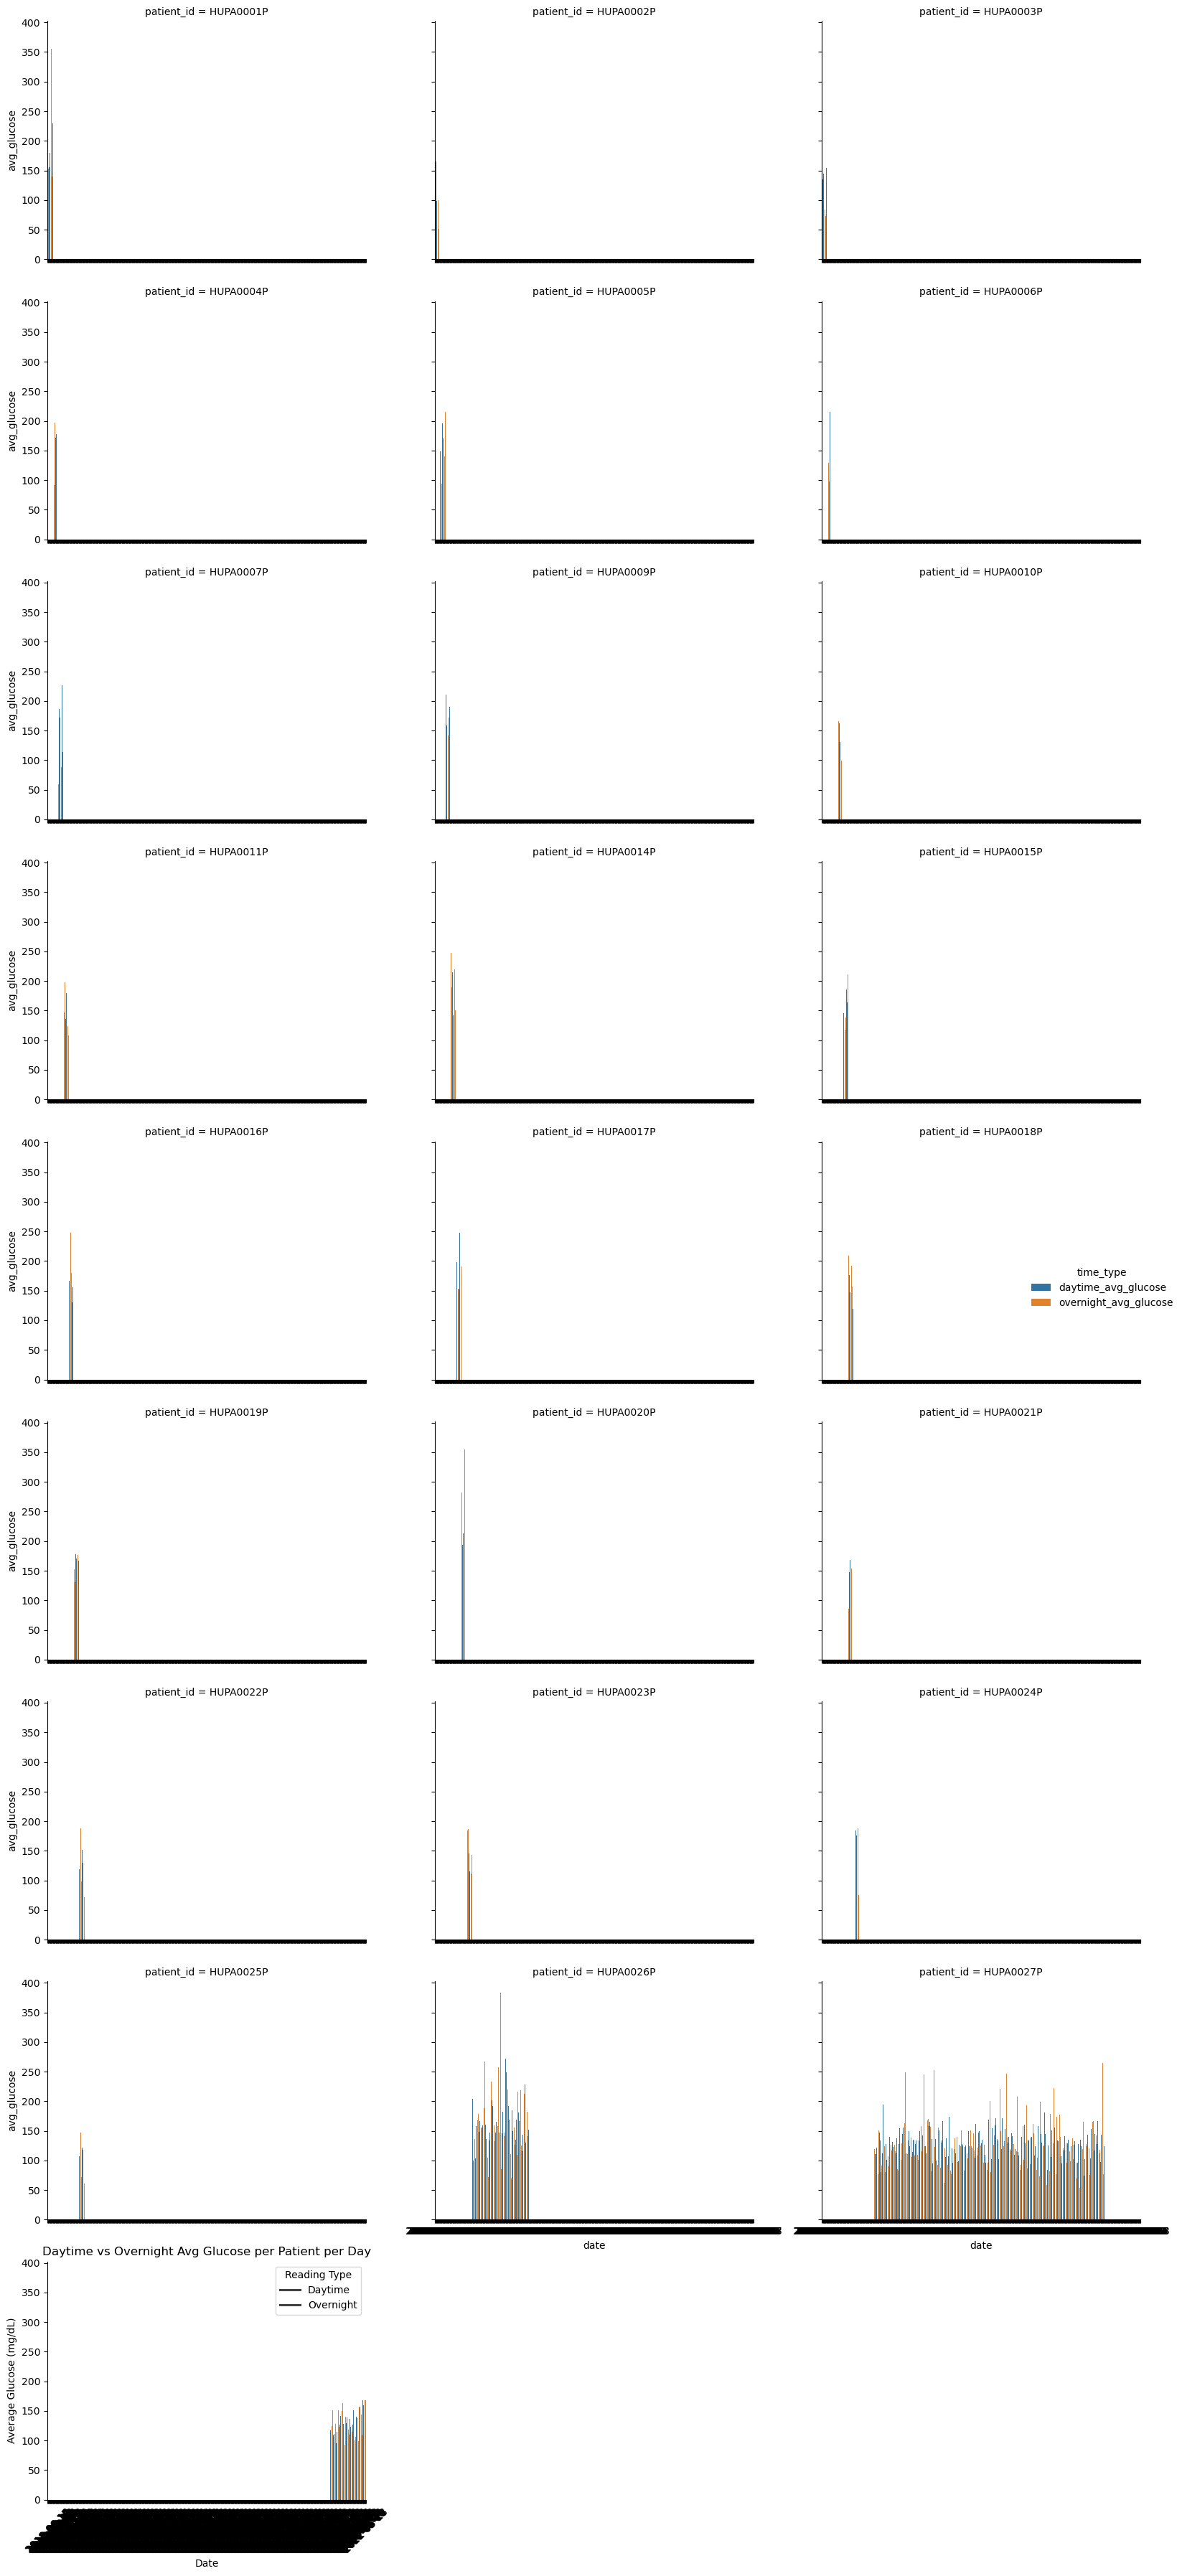

In [25]:
plt.figure(figsize=(14,6))
sns.catplot(
    data=plot_df,         # the DataFrame you are plotting
    x="date", y="avg_glucose",   # what goes on x-axis and y-axis
    hue="time_type",      # separate bars/colors for Daytime vs Overnight
    kind="bar",           # bar chart (can be 'point', 'box', 'violin', etc.)
    col="patient_id",     # separate chart (facet) for each patient
    col_wrap=3,           # wrap charts into rows of 3 plots each
    height=4, aspect=1.2  # control size of each small chart
)
plt.title("Daytime vs Overnight Avg Glucose per Patient per Day")
plt.xlabel("Date")
plt.ylabel("Average Glucose (mg/dL)")
plt.xticks(rotation=45)
plt.legend(title="Reading Type", labels=["Daytime", "Overnight"])
plt.tight_layout()
plt.show()


/tmp/ipykernel_29/4015494387.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


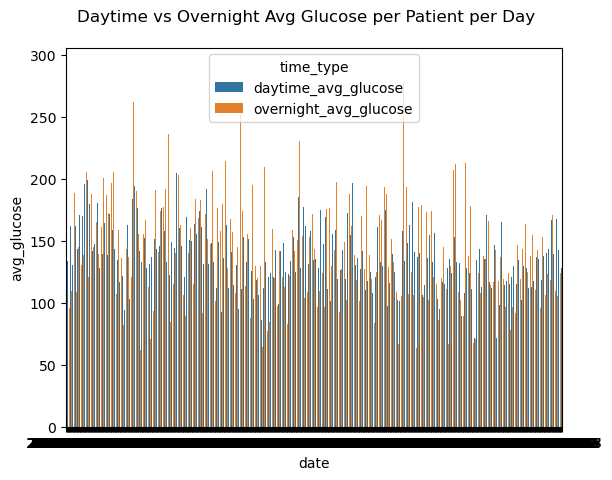

In [26]:
# plot_df = result_df.melt(
#     id_vars=["patient_id", "date"],
#     value_vars=["daytime_avg_glucose", "overnight_avg_glucose"],
#     var_name="time_type",
#     value_name="avg_glucose"
# )

# Plot separate charts per patient
sns.barplot(
    data=plot_df,
    x="date", y="avg_glucose",
    hue="time_type",
    ci=None
)

plt.subplots_adjust(top=0.9)
plt.suptitle("Daytime vs Overnight Avg Glucose per Patient per Day")
plt.show()

/tmp/ipykernel_29/1366417036.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_29/1366417036.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_29/1366417036.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


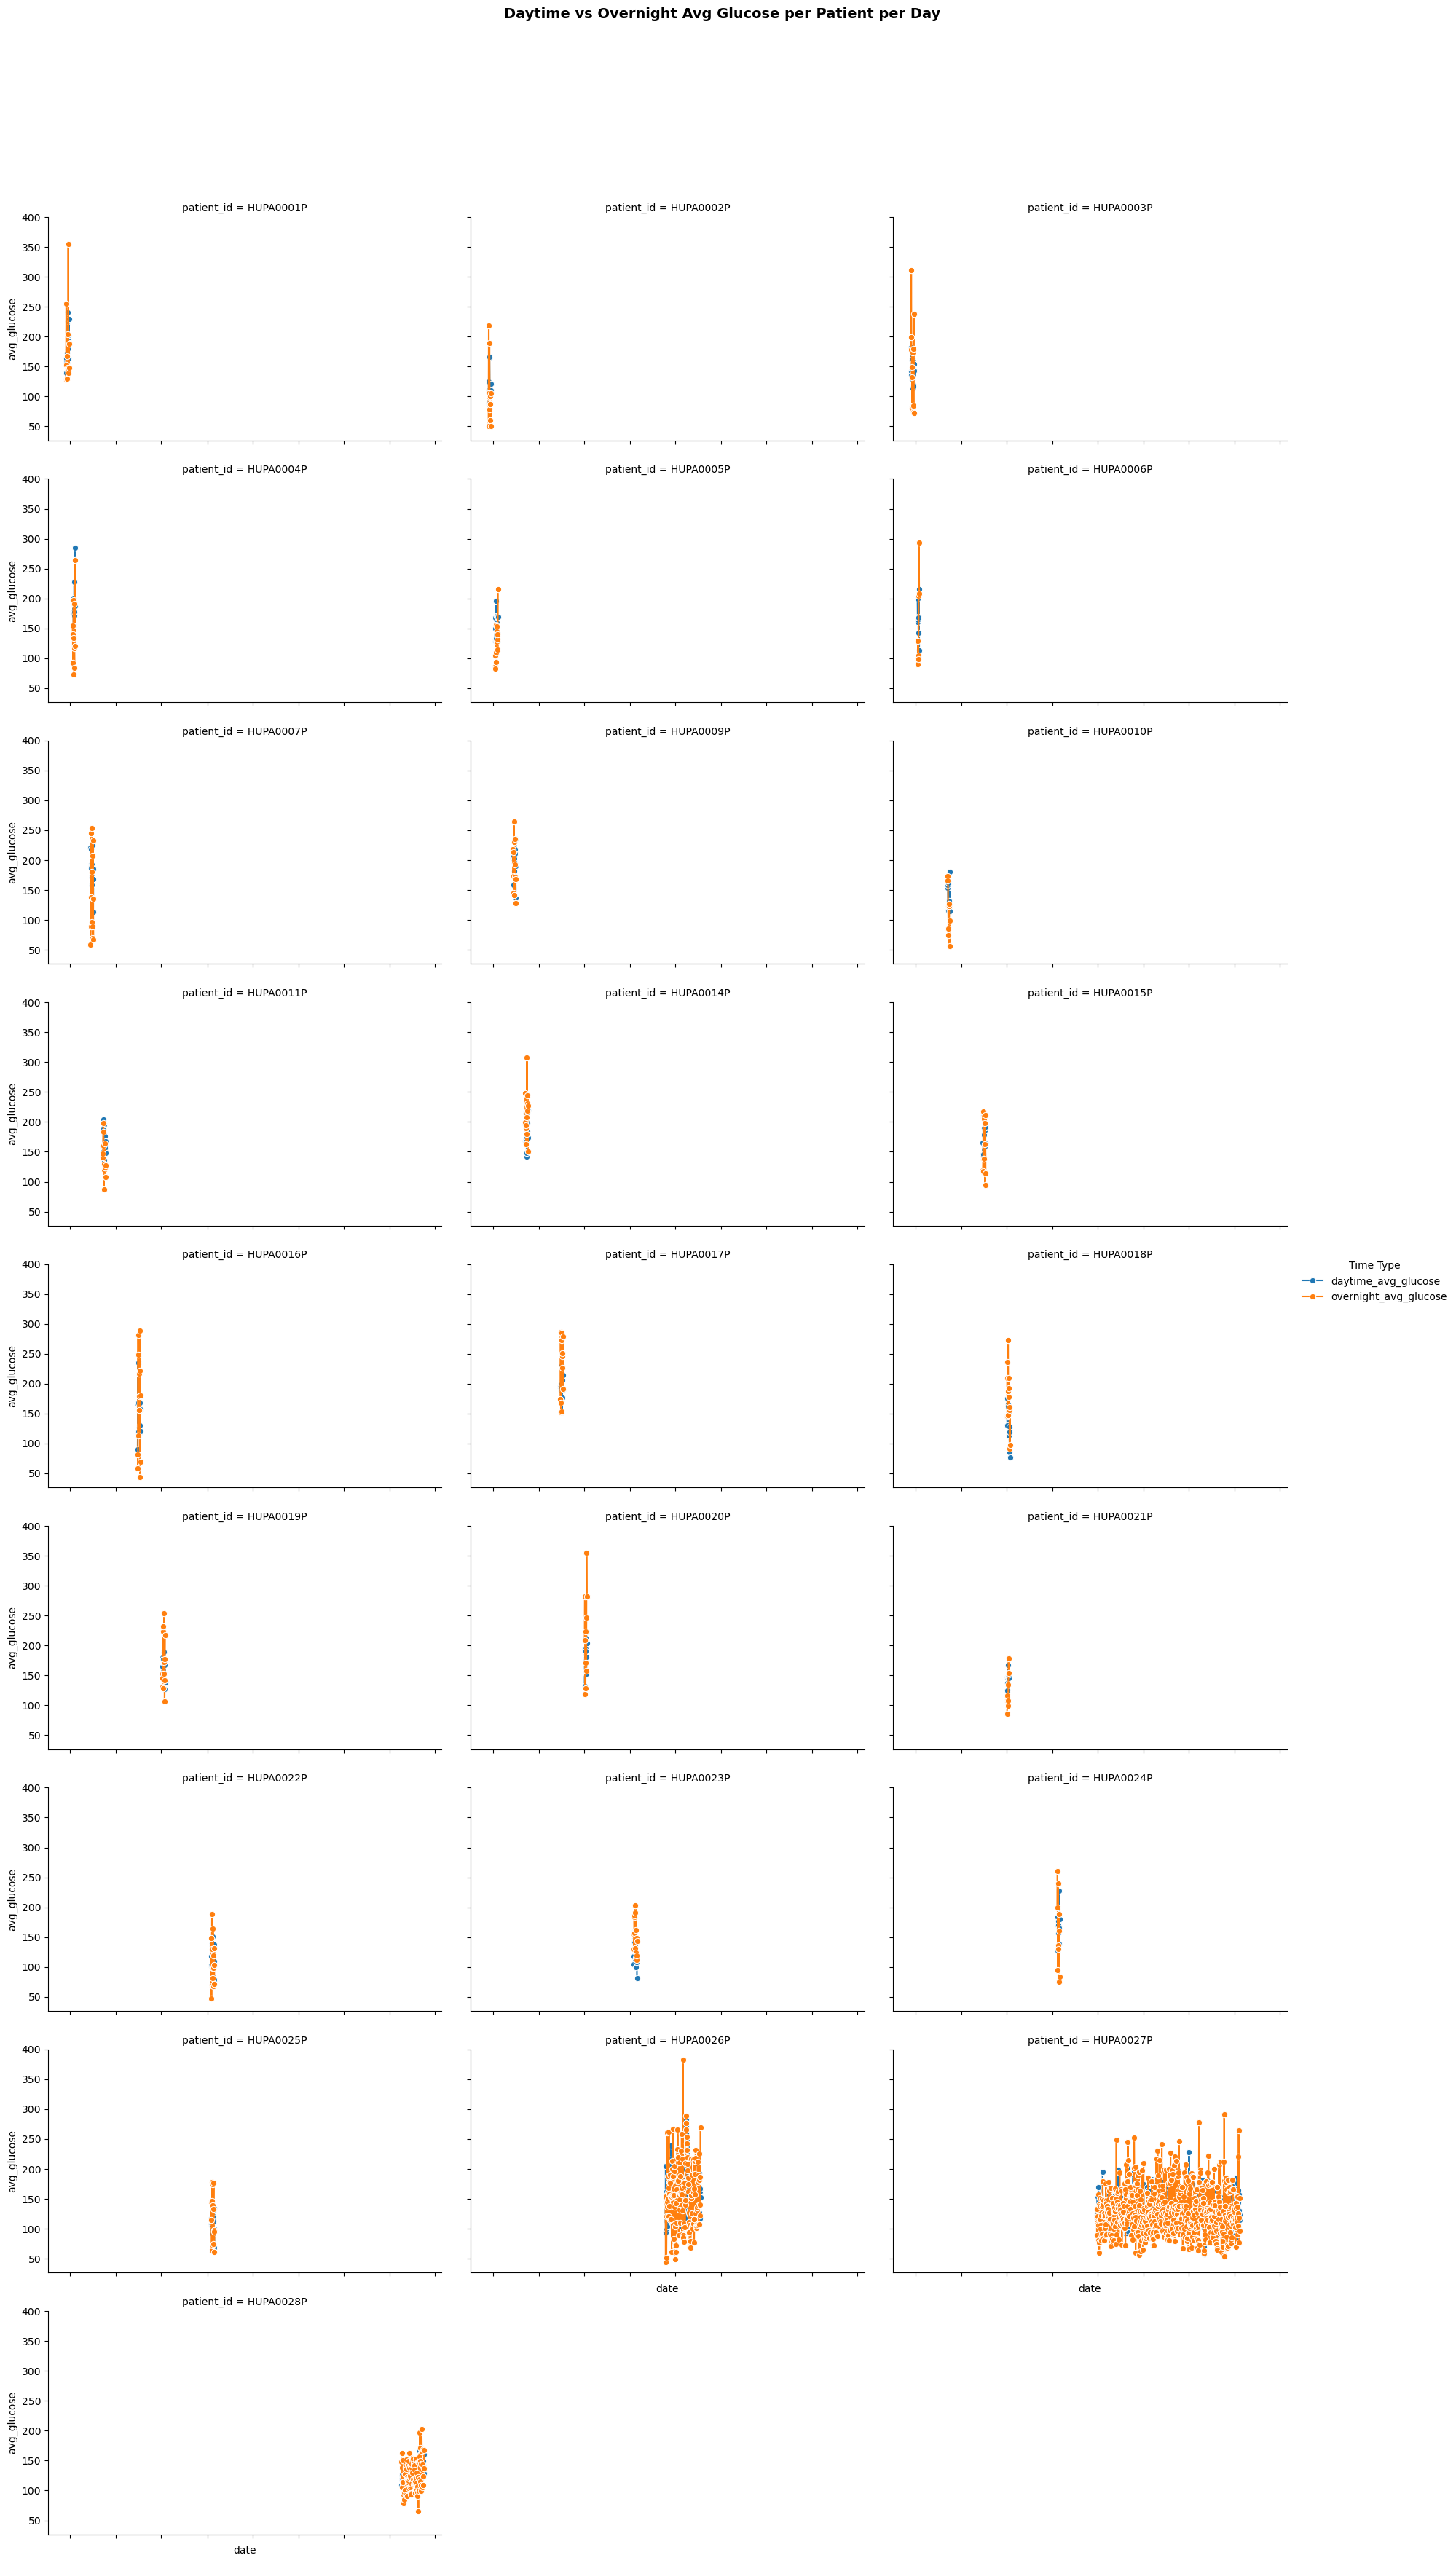

In [23]:
plot_df["date"] = pd.to_datetime(plot_df["date"])

# Separate line chart per patient
g = sns.FacetGrid(
    plot_df, 
    col="patient_id", 
    col_wrap=3, 
    height=4, 
    aspect=1.5
)

# Draw line plot with markers
g.map_dataframe(
    sns.lineplot, 
    x="date", 
    y="avg_glucose", 
    hue="time_type", 
    marker="o"
)

# Rotate dates on x-axis
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust legends
g.add_legend(title="Time Type")

plt.subplots_adjust(top=0.9)
plt.suptitle("Daytime vs Overnight Avg Glucose per Patient per Day", fontsize=14, weight="bold")
plt.show()

In [76]:
patients_demographic_df= patients_demographic_df.round({'heart_rate':0,'glucose':1})
patients_demographic_df.columns
#patients_demographic_df

Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input', 'patient_id', 'age', 'gender',
       'race', 'avg_sleep_duration_hrs', 'sleep_quality_score',
       'sleep_disturbances_percentage'],
      dtype='object')

In [80]:
df = patients_demographic_df.loc[:,['patient_id','age','gender','race','sleep_disturbances_percentage','heart_rate']]
result_df = df[['sleep_disturbances_percentage','age','heart_rate']].corr()
result_df
#df = patients_demographic_df.loc[(patients_demographic_df['age']>40),['patient_id','age','gender','race','sleep_disturbances_percentage','heart_rate']]
df = patients_demographic_df.loc[:,['patient_id','age','gender','race','avg_sleep_duration_hrs','heart_rate']]
result_df = df[['avg_sleep_duration_hrs','age','heart_rate']].corr()
result_df
df = patients_demographic_df.loc[:,['patient_id','glucose','age','gender','avg_sleep_duration_hrs','race','sleep_disturbances_percentage','heart_rate']]
df
result_df = df[['avg_sleep_duration_hrs','age','heart_rate','glucose']].corr()
result_df

,avg_sleep_duration_hrs,age,heart_rate,glucose
avg_sleep_duration_hrs,1.000000,-0.522143,-0.029933,0.124633
age,-0.522143,1.000000,-0.041871,-0.157278
heart_rate,-0.029933,-0.041871,1.000000,0.098305
glucose,0.124633,-0.157278,0.098305,1.000000


In [85]:
# Correlation matrix
# corr = df[['avg_sleep_duration_hrs','age','heart_rate','glucose']].corr()

# plt.figure(figsize=(8,6))
# sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Heatmap")
# plt.show()

In [451]:
patients_demographic_df['time'].dt.date.unique()
#patients_demographic_df['time'].dt.year, 
 #                                  patients_demographic_df['time'].dt.month,
patients_demographic_df['year']= patients_demographic_df['time'].dt.year
patients_demographic_df['month']= patients_demographic_df['time'].dt.month
patients_demographic_df.columns
#df= patients_demographic_df.groupby(['patient_id','year','month','age','gender'])['glucose'].mean().reset_index()
df= patients_demographic_df.groupby(['patient_id','year','month'])['glucose'].mean().reset_index()
df_sorted = df.sort_values(by =['patient_id','year','month'])
df_sorted



,patient_id,year,month,glucose
0,HUPA0001P,2018,6,181.443726
1,HUPA0002P,2018,6,113.469632
2,HUPA0003P,2018,6,143.273528
3,HUPA0004P,2018,7,180.377984
4,HUPA0005P,2018,7,147.698600
5,HUPA0006P,2018,7,165.204585
6,HUPA0007P,2018,9,179.451020
7,HUPA0007P,2018,10,137.124564
8,HUPA0009P,2018,9,198.222219
9,HUPA0009P,2018,10,166.039548


In [467]:
#find records from 
# Filtered patients_df to get required columns of the dataset 
patients_df.columns

df = patients_df.loc[:,['patient_id','year','month','glucose']]

#df['patient_id'].nunique()
# For caluclating hbA1c,average glucose values per month is required 
# So calculated the mean glucose by grouping with the patientid, year and month
df = df.groupby(['patient_id','year','month'])['glucose'].mean().reset_index()
#df
# Extract the month count per patients per year during with glucose data is available
#month_cnt_df = df.groupby(['patient_id','year'])['month'].nunique().reset_index(name='month_cnt')
#Modified to check if records availble during Dec
#month_cnt_df = df.groupby(['patient_id'])['month'].nunique().reset_index(name='month_cnt')
# Delete the records if the data is not avaibale for 3 or more months
#month_cnt_df = month_cnt_df[month_cnt_df['month_cnt']>2]
#month_cnt_df
# for dec
#df1 = pd.merge(df[['patient_id','month','glucose','year']],month_cnt_df[['patient_id','year','month_cnt']],on=['patient_id','year'], how="inner")
#df1.sort_values(by = ['patient_id','year','month'])
# length = len(df1)
#df1

KeyError: "['year', 'month'] not in index"

<pre><strong>Descriptive and Time-Series Analysis with clinical interpretation.
calculate the HbA1c levels for each patient. 
HbA1c should be estimated based on the average glucose over 3 consecutive months. 
In this analysis, only the patients who have complete data for 3 consecutive months are considered for the years 2020-2022. 
Formula used to calculate HbA1c is: 
    hb1ac = (mean_glucose + 46.7) / 28.7
The analysis also identifies the  patients with elevated HbA1c (>6.4%) 
and provides furthur insights through comparisons based on demographic factors like gender, age, and race.</string></pre>

In [530]:
# Make a temparay copy of patients df 
temp_df = patients_df.copy()
temp_df['year'] = df['time'].dt.year
temp_df['month'] = df['time'].dt.month
temp_df = temp_df.loc[:,['patient_id','year','month','glucose']]

# For caluclating hbA1c,average glucose values per month is required 
# So calculated the mean glucose by grouping with the patientid, year and month
temp_df = temp_df.groupby(['patient_id','year','month'])['glucose'].mean().reset_index()

# Extract the month count per patients per year during witch glucose data is available
#month_cnt_df = temp_df.groupby(['patient_id','year'])['month'].nunique().reset_index(name='month_cnt')
month1_cnt_df = temp_df.groupby(['patient_id'])['month'].count().reset_index(name='month_cnt')
# print(month_cnt_df.count())
# print()
# print(month1_cnt_df.count())
# print(month_cnt_df['month_cnt'].equals(month1_cnt_df['month_cnt']))
# print(month_cnt_df['month_cnt'].sum())
# print(month1_cnt_df['month_cnt'].sum())

# print(month_cnt_df['month_cnt'].to_list())
# print(month1_cnt_df['month_cnt'].to_list())
#temp1_df = pd.merge(temp_df[['patient_id','month','glucose','year']],month_cnt_df[['patient_id','year','month_cnt']],on=['patient_id','year'], how="inner")
#temp1_df.sort_values(by = ['patient_id','year','month'])
#month_cnt_df = month_cnt_df[month_cnt_df['month_cnt']>2]
month1_cnt_df = month1_cnt_df[month1_cnt_df['month_cnt']>2]

temp1_df = pd.merge(temp_df[['patient_id','month','glucose','year']],month1_cnt_df[['patient_id','month_cnt']],on=['patient_id'], how="inner")
temp1_df.sort_values(by = ['patient_id','year','month'])

# length = len(df1)
#temp1_df

patient_id    57
year          57
month         57
glucose       57
dtype: int64


,patient_id,month,glucose,year,month_cnt
0,HUPA0026P,5,136.701333,2020,6
1,HUPA0026P,6,168.500174,2020,6
2,HUPA0026P,7,157.924927,2020,6
3,HUPA0026P,8,176.705281,2020,6
4,HUPA0026P,9,157.060822,2020,6
5,HUPA0026P,10,160.997049,2020,6
6,HUPA0027P,6,124.920290,2020,20
7,HUPA0027P,7,119.454385,2020,20
8,HUPA0027P,8,127.083277,2020,20
9,HUPA0027P,9,131.058160,2020,20


In [531]:
#month1_cnt_df['patient_id'].unique()
temp1_df
#print(temp_df.groupby(['patient_id'])['month'].count())

,patient_id,month,glucose,year,month_cnt
0,HUPA0026P,5,136.701333,2020,6
1,HUPA0026P,6,168.500174,2020,6
2,HUPA0026P,7,157.924927,2020,6
3,HUPA0026P,8,176.705281,2020,6
4,HUPA0026P,9,157.060822,2020,6
5,HUPA0026P,10,160.997049,2020,6
6,HUPA0027P,6,124.920290,2020,20
7,HUPA0027P,7,119.454385,2020,20
8,HUPA0027P,8,127.083277,2020,20
9,HUPA0027P,9,131.058160,2020,20


In [535]:

HbA1c = []

for i in range(0,len(df1),3):
    avg_glucose=0
    df_month = temp1_df.iloc[i:i+3]
    if len(df_month)==3:
        # print(df_month['patient_id'])
        # print(df_month['month'])
        # print(df_month['year'])
        patient_ids = df_month['patient_id'].unique()
        years = df_month['year'].unique()
        months = df_month['month'].sort_values().to_list()
          # Check if all rows belong to same patient + year
        if len(patient_ids) == 1: #and len(years) == 1:
         # Convert year + month into continuous number
         # to handle year boundaries and check for consecutive months properly.
            month_nums = df_month['year'] * 12 + df_month['month']
            #print('monthnums', month_nums)
            month_nums_sorted = month_nums.sort_values().to_list()

            # Check if months are consecutive
            if month_nums_sorted[2] - month_nums_sorted[0] == 2:  #and sorted(months) == months:
                mean_glucose = df_month['glucose'].mean()
                hb1ac = (mean_glucose + 46.7) / 28.7
                # print(f"Patient: {patient_ids[0]}, Year: {years[0]}, "
                #        f"Months: {months}, Mean Glucose: {mean_glucose:.2f}, "
                #        f"HbA1c: {hb1ac:.2f}%")
                HbA1c.append({
                    'patient_id': patient_ids[0],
                    'year': years[0],
                    'months': months,
                    'mean_glucose': mean_glucose,
                    'HbA1c': hb1ac
                })
                i=i+3
            else:
                i+=1
        else:
            i+=1
HbA1c_df = pd.DataFrame(HbA1c)
HbA1c_df


,patient_id,year,months,mean_glucose,HbA1c
0,HUPA0026P,2020,"[5, 6, 7]",154.375478,7.006114
1,HUPA0026P,2020,"[8, 9, 10]",164.921051,7.373556
2,HUPA0027P,2020,"[6, 7, 8]",123.819317,5.941440
3,HUPA0027P,2020,"[9, 10, 11]",134.726974,6.321497
4,HUPA0027P,2020,"[1, 2, 12]",130.106281,6.160498
5,HUPA0027P,2021,"[3, 4, 5]",138.441115,6.450910
6,HUPA0027P,2021,"[6, 7, 8]",131.192127,6.198332
7,HUPA0027P,2021,"[9, 10, 11]",128.329994,6.098606
8,HUPA0028P,2022,"[3, 4, 5]",132.502353,6.243984


In [540]:
HbA1c_df= HbA1c_df.round({'mean_glucose':1,'HbA1c':1})
print(HbA1c_df['patient_id'].nunique())

HbA1c_df



3


,patient_id,year,months,mean_glucose,HbA1c
0,HUPA0026P,2020,"[5, 6, 7]",154.4,7.0
1,HUPA0026P,2020,"[8, 9, 10]",164.9,7.4
2,HUPA0027P,2020,"[6, 7, 8]",123.8,5.9
3,HUPA0027P,2020,"[9, 10, 11]",134.7,6.3
4,HUPA0027P,2020,"[1, 2, 12]",130.1,6.2
5,HUPA0027P,2021,"[3, 4, 5]",138.4,6.5
6,HUPA0027P,2021,"[6, 7, 8]",131.2,6.2
7,HUPA0027P,2021,"[9, 10, 11]",128.3,6.1
8,HUPA0028P,2022,"[3, 4, 5]",132.5,6.2


In [541]:
HbA1c_df= HbA1c_df.round({'mean_glucose':1,'HbA1c':1})
# Total number of patients whose data permits calculation of HbA1c
print('Total number of patients whose data permits calculation of HbA1c for the years 2020-2022')
print(HbA1c_df['patient_id'].nunique())
print('-----------------------------------------------')

#Diabetic
# Number of patients diagnosed with diabetes [having HbA1c > 6.4]
print("Number of patients diagnosed with diabetes [having HbA1c > 6.4]")
print(HbA1c_df.loc[HbA1c_df['HbA1c']>=6.4,'patient_id'].nunique())
print('-----------------------------------------------')

#Prediabetic/High risk
# Number of patients who are on hign risk 
print('Number of patients who are on hign risk having [6.4 > Hb1Ac > 5.7] ')
print(HbA1c_df.loc[((HbA1c_df['HbA1c']<6.4) & (HbA1c_df['HbA1c']>5.7)),'patient_id'].nunique())
print('-----------------------------------------------')

# Normal / Non diabetic
# Number of patients are non diabetic
print('Number of patients are non diabetic [Hb1Ac< 5.7]')
print(HbA1c_df.loc[(HbA1c_df['HbA1c']<5.7),'patient_id'].nunique())
print('-----------------------------------------------')

# Poorly controlled diabetes
# Number of Patients with poorly controlled diabetes 
print('Number of Patients with poorly controlled diabetes')
print(HbA1c_df.loc[(HbA1c_df['HbA1c']>8.0), 'patient_id'].nunique())
print('-----------------------------------------------')

# moderate but generally acceptable blood sugar control 
# Number of patients with acceptable blood 
print('Number of patients with acceptable blood sugar')
print(HbA1c_df.loc[(HbA1c_df['HbA1c']>7.0) & (HbA1c_df['HbA1c']<8.0),'patient_id'].nunique())
print('-----------------------------------------------')


# Male-to-Female ratio among diabetic patients
# Preparing data set
# Filtered patients with diabetes
diabetes_patients= HbA1c_df.loc[(HbA1c_df['HbA1c']>6.4),'patient_id']

# Merged with demographi_df to include age and gender information
diabetes_patient_df = pd.merge(diabetes_patients,demographic_df[['patient_id','age','gender','race']],on='patient_id',how="inner")

# Deleting duplicates patient ids as patients have multiple H1bAc values for different months
diabetes_patient_df = diabetes_patient_df.drop_duplicates()

#count male/female patients
gender_df = diabetes_patient_df['gender'].value_counts()

print('Number of Male and Female Patients ')
print(gender_df.to_string(index=True, header=False))

#Ratio Male/Female
ratio = gender_df['Male']/gender_df['Female']
print('Male to Female Ratio: ',ratio)
print('-----------------------------------------------')

#Age distribution of diabetes patients
print('Age distribution of diabetes patients: ')
print('Youngest Patient Age: ', diabetes_patient_df['age'].min())
print('Oldest Patient Age: ', diabetes_patient_df['age'].max())
print('-----------------------------------------------')

#Distribution of Diabetes Patients by Race
print('Race of patients diagnosed with diabetes')
print(diabetes_patient_df['race'].unique())
print('-----------------------------------------------')


Total number of patients whose data permits calculation of HbA1c
3
-----------------------------------------------
Number of patients diagnosed with diabetes [having HbA1c > 6.4]
2
-----------------------------------------------
Number of patients who are on hign risk having [6.4 > Hb1Ac > 5.7] 
2
-----------------------------------------------
Number of patients are non diabetic [Hb1Ac< 5.7]
0
-----------------------------------------------
Number of Patients with poorly controlled diabetes
0
-----------------------------------------------
Number of patients with acceptable blood sugar
1
-----------------------------------------------
Number of Male and Female Patients 
Male      1
Female    1
Male to Female Ratio:  1.0
-----------------------------------------------
Age distribution of diabetes patients: 
Youngest Patient Age:  33
Oldest Patient Age:  60
-----------------------------------------------
Race of patients diagnosed with diabetes
['Hispanic' 'Black']
---------------------

In [582]:
# Merged with demographi_df to include age and gender information
hba1c_plot_df = pd.merge(HbA1c_df,demographic_df[['patient_id','age','gender','race']],on='patient_id',how="inner")
hba1c_plot_df
# Convert numeric 'months' to readable Year-Month
# extract year + month from continuous number
def numeric_month_to_ym(month_nums):
    m = month_nums
    year = (m-1)//12
    month = (m-1)%12 + 1
    return f"{year}-{month:02d}"  #returninf year in 4 digits and month in 2 digits

# Create new column to convert year + month into continuous number
# This helps 
#hba1c_plot_df['yearMonth'] = hba1c_plot_df['year'] * 12 + hba1c_plot_df['months'].apply(lambda x:x[0])
hba1c_plot_df['year_month'] = hba1c_plot_df['year'].astype(str)+'-'+ hba1c_plot_df['months'].apply(lambda x:str(x[0]).zfill(2))
#print(hba1c_plot_df[hba1c_plot_df['year_month']])
#.apply() method used to apply a function to each row of a DataFrame 
# to perform custom operations without writing explicit loops.
#hba1c_plot_df['year_month'] = hba1c_plot_df['yearMonth'].apply(numeric_month_to_ym)

# For visualization, sort by Year-Month
hba1c_plot_df = hba1c_plot_df.sort_values(['patient_id','year_month']).reset_index(drop=True)
hba1c_plot_df
#month_nums

,patient_id,year,months,mean_glucose,HbA1c,age,gender,race,year_month
0,HUPA0026P,2020,"[5, 6, 7]",154.4,7.0,33,Male,Hispanic,2020-05
1,HUPA0026P,2020,"[8, 9, 10]",164.9,7.4,33,Male,Hispanic,2020-08
2,HUPA0027P,2020,"[1, 2, 12]",130.1,6.2,60,Female,Black,2020-01
3,HUPA0027P,2020,"[6, 7, 8]",123.8,5.9,60,Female,Black,2020-06
4,HUPA0027P,2020,"[9, 10, 11]",134.7,6.3,60,Female,Black,2020-09
5,HUPA0027P,2021,"[3, 4, 5]",138.4,6.5,60,Female,Black,2021-03
6,HUPA0027P,2021,"[6, 7, 8]",131.2,6.2,60,Female,Black,2021-06
7,HUPA0027P,2021,"[9, 10, 11]",128.3,6.1,60,Female,Black,2021-09
8,HUPA0028P,2022,"[3, 4, 5]",132.5,6.2,62,Male,Black,2022-03


<pre><strong>Heatmap Analysis of HbA1c/Glucose Levels (2020–2022)
A heatmap was generated to visualize the monthly glucose/HbA1c trends across patients. 
Each row represents a patient, and each column represents a month within the study period. 
The color intensity reflects the mean glucose (or derived HbA1c) value for that patient in a given month.
Rows: Patient IDs
Columns: Months (Jan 2020 → Dec 2022)
Values: Average glucose or HbA1c
Optional: Use color to indicate levels</strong></pre>

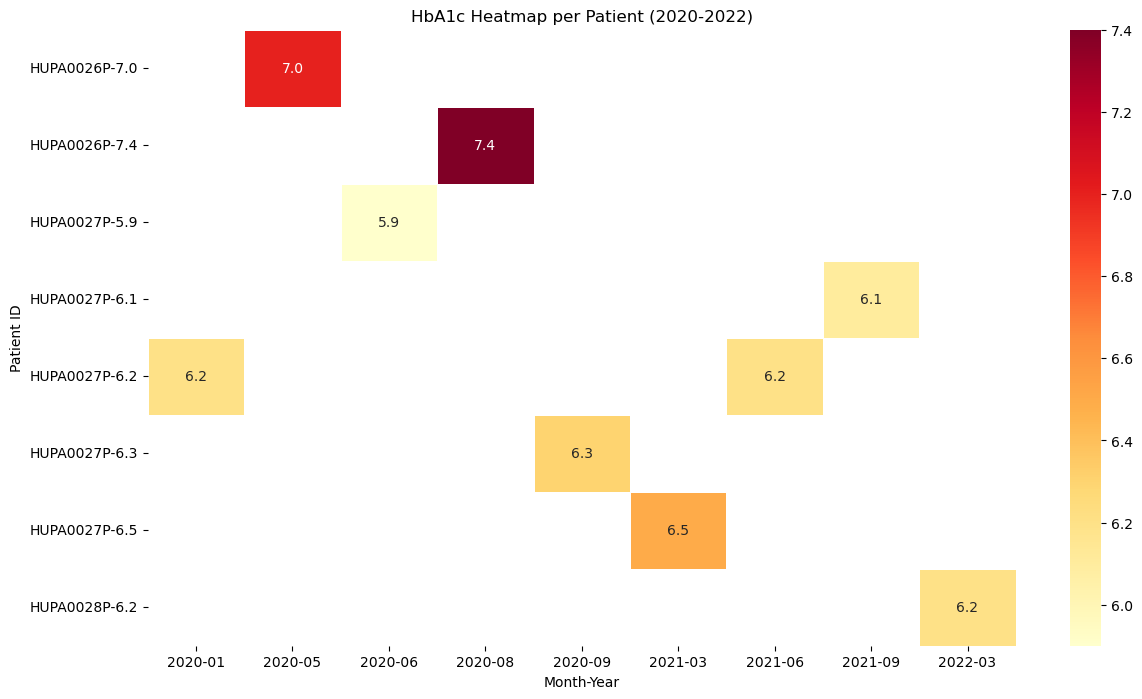

In [583]:
# Pivot table: rows=patient_id, columns=year_month, values=HbA1c
heatmap_df = hba1c_plot_df.pivot(index=['patient_id','HbA1c'], columns='year_month', values='HbA1c')

plt.figure(figsize=(14,8))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap='YlOrRd', linewidths=.5)
plt.title("HbA1c Heatmap per Patient (2020-2022)")
plt.ylabel("Patient ID")
plt.xlabel("Month-Year")
plt.show()